## Instruction
In this notebook, We use data which I donwload from Tushare to make up some alpha factors and risk factors.
1. Load data from Tushare time range bettwen 2017.1 - 2023.3.
2. Calculate portfolio risk by PCA and save idiosynchritic values view a factor
3. Make up some factors like we did in P4 project.
5. Evaluate factor returns in 5D, 20D, 60D, 120D. and seperate factors into two parts, risk factors and alpha factors.

## Load Data

In [1]:
import pandas as pd 
import numpy as np
from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]

import warnings
warnings.filterwarnings('ignore')

In [2]:
universe_raw = pd.read_csv('raw_20170103_20230317.csv').iloc[:,1:]
fundamental_df = pd.read_csv('fundamental_20170103_20230317.csv').iloc[:,1:]

## Data Explain
  Fundamental indicators
  - 'cfps','revenue_ps', 'quick_ratio',  每股现金流，每股营业收入，速冻比率
  - 'dt_eps','basic_eps_yoy','dt_eps_yoy',  每股收益
  - 'bps','bps_yoy',  每股净资产
  - 'extra_item','profit_dedt', 扣非，扣非净利润，扣费净利润单季度 
  - 'roe_dt','q_dt_roe','roe_yoy',  净资产收益
  - 'capital_rese_ps','surplus_rese_ps',  每股资本公积，每股公积盈余 
  - 'gross_margin','interestdebt','ca_to_assets', 毛利，速冻比率，带息债务
  - 'ebt_yoy','roe_yoy','or_yoy','equity_yoy' 总利润增长，净资产收益增长，营业收入增长，净资产增长

In [3]:
print(universe_raw.shape, len(fundamental_df.ts_code.unique()))
print(universe_raw.columns)
universe_raw.loc[universe_raw.ts_code=='000004.SZ']

(867437, 57) 746
Index(['ts_code', 'trade_date', 'turnover_rate', 'volume_ratio', 'pe', 'pb',
       'total_share', 'free_share', 'total_mv', 'circ_mv', 'name', 'industry',
       'list_date', 'amount', 'adj_factor', 'open', 'close', 'high', 'low',
       'macd', 'rsi_6', 'rsi_12', 'rsi_24', 'boll_upper', 'boll_mid',
       'boll_lower', 'cci', 'date', 'pct_change', 'type', 'p_change_min',
       'p_change_max', 'issue_price', 'issue_amount', 'type_value', 'cfps',
       'revenue_ps', 'quick_ratio', 'dt_eps', 'basic_eps_yoy', 'dt_eps_yoy',
       'bps', 'bps_yoy', 'extra_item', 'profit_dedt', 'roe_dt', 'q_dt_roe',
       'roe_yoy', 'capital_rese_ps', 'surplus_rese_ps', 'gross_margin',
       'interestdebt', 'ca_to_assets', 'ebt_yoy', 'roe_yoy.1', 'or_yoy',
       'equity_yoy'],
      dtype='object')


,ts_code,trade_date,turnover_rate,volume_ratio,pe,pb,total_share,free_share,total_mv,circ_mv,...,roe_yoy,capital_rese_ps,surplus_rese_ps,gross_margin,interestdebt,ca_to_assets,ebt_yoy,roe_yoy.1,or_yoy,equity_yoy
0,000004.SZ,20170103,0.8624,0.79,2993.1111,38.7934,8397.6684,4927.5841,373276.3604,368763.3519,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000004.SZ,20170104,1.0510,0.95,3009.9453,39.0115,8397.6684,4927.5841,375375.7775,370837.3865,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000004.SZ,20170105,1.2367,1.24,2992.4377,38.7846,8397.6684,4927.5841,373192.3837,368680.3905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000004.SZ,20170106,0.8018,0.75,2960.1162,38.3657,8397.6684,4927.5841,369161.5029,364698.2441,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000004.SZ,20170109,1.4952,1.52,2896.1464,37.5366,8397.6684,4927.5841,361183.7179,356816.9126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1428,000004.SZ,20230313,1.0738,0.91,1000.0000,1.4912,13284.8008,8650.0178,132848.0080,118916.8530,...,-381.512,9.2717,0.101,40512024.46,1832840.85,52.7746,-292.6085,-381.512,-49.3267,-40.2295
1429,000004.SZ,20230314,1.3599,1.11,1000.0000,1.4554,13284.8008,8650.0178,129659.6558,116062.8485,...,-381.512,9.2717,0.101,40512024.46,1832840.85,52.7746,-292.6085,-381.512,-49.3267,-40.2295
1430,000004.SZ,20230315,0.7478,0.58,1000.0000,1.4658,13284.8008,8650.0178,130589.5919,116895.2665,...,-381.512,9.2717,0.101,40512024.46,1832840.85,52.7746,-292.6085,-381.512,-49.3267,-40.2295
1431,000004.SZ,20230316,0.9221,0.77,1000.0000,1.4524,13284.8008,8650.0178,129393.9598,115825.0148,...,-381.512,9.2717,0.101,40512024.46,1832840.85,52.7746,-292.6085,-381.512,-49.3267,-40.2295


## Add Technology Indicators

In [4]:
# add volume
universe_raw['volume'] = universe_raw['amount']/universe_raw['close']

In [5]:
import stockstats

class IndicatorHelper(pd.DataFrame):
    """
        add indicators to dataframe
    """

    def __init__(self, data):
        super(IndicatorHelper, self).__init__(data)

        self.stocks = stockstats.StockDataFrame.retype(data.copy())
        self.df = self

    def add_technical_indicator(self, tech_indicator_list):
        """
        calculate technical indicators
        use stockstats package to add technical inidactors
        :param ticker: (df) pandas dataframe
        :param tech_indeicator_list list
        :return: (df) pandas dataframe
        """
        unique_ticker = self.df.ts_code.unique()

        indicator_df = pd.DataFrame()
        for i in tqdm(range(len(unique_ticker)), desc='add tech indicators'):
            temp_indicator = self.stocks[self.stocks.ts_code == unique_ticker[i]][tech_indicator_list + ['ts_code','trade_date']]
            indicator_df = indicator_df.append(temp_indicator, ignore_index=True)

        self.df = self.df.merge(indicator_df, on=["ts_code", "trade_date"], how="left")
        self.df = self.df.sort_values(by=["trade_date", "ts_code"])
        return self.df
    

In [6]:
# add tech indicators
tech_indicator_list = ['supertrend', 'supertrend_lb','supertrend_ub',
                       'close_5_sma','close_20_sma','close_60_sma',
                       'log-ret','atr_5','ppo','cci_6', 
                       'close_10_kama_2_30', 'close_10_kama_5_30','close_2_kama'] 
universe = IndicatorHelper(universe_raw).add_technical_indicator(tech_indicator_list)

# 'close_2_kama_20_mstd'

add tech indicators: 100%|████████████████████| 746/746 [11:03<00:00,  1.12it/s]


In [9]:
# set date time as index
universe['date'] = pd.to_datetime(universe['date'])
universe = universe.set_index('date')

## Constructor Factors Based on Indicators

### Supertrend Factors
This factor based on supertrend and close 5 days sma

In [10]:
universe['alpha_supertrend'] = universe['close_5_sma'] - universe['supertrend']

### CCI Factors
This factor based on cci and atr 5 days window

In [11]:
universe['alpha_cci'] = -np.where(universe['cci']>150, (universe['cci']-150)*universe['atr_5'], \
                      np.where(universe['cci']<-150, (universe['cci']+150)*universe['atr_5'], universe['atr_5']*30))

### KAMA Factors

In [ ]:
universe.to_csv('factor_tmp.csv')

In [214]:
# add KAMA filter
def KAMA_filter(df):    
    unique_stocks = df.ts_code.unique()
    df.reset_index(inplace = True)
    all_df = pd.DataFrame()
    for ts_code in tqdm(unique_stocks, desc='kama filter'):
        tmp = df.loc[df.ts_code == ts_code]
        tmp['close_2_kama'] = tmp['close_2_kama'].fillna(method='ffill')
        tmp['kama_filter'] = tmp['close_2_kama'].rolling(window=20).std().fillna(method='bfill') * 0.6
        tmp['kama_prior'] = tmp['close_2_kama'].shift(-5).fillna(method='ffill')
        tmp['alpha_kama'] = (tmp['close_10_kama_2_30'] - tmp['close_10_kama_5_30'])-(tmp['close_2_kama'] - tmp['kama_prior'] - tmp['kama_filter'])
        all_df = all_df.append(tmp[['ts_code','trade_date','alpha_kama']], ignore_index=True)
    df = df.merge(all_df, on=['ts_code','trade_date'], how='left')
    df = df.set_index(['date']).sort_values(by=['date'])
    return df

#mnh = universe.loc[universe.ts_code=='300277.SZ']
#mnh = universe.loc[universe.ts_code=='603538.SH']
#mnh = KAMA_filter(mnh)
universe = KAMA_filter(universe)

kama filter: 100%|████████████████████████████████| 1/1 [00:00<00:00, 98.83it/s]


<AxesSubplot:xlabel='date'>

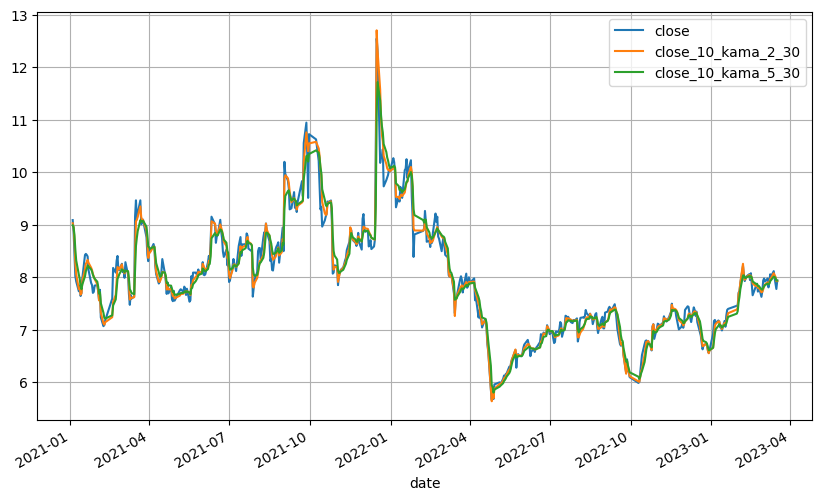

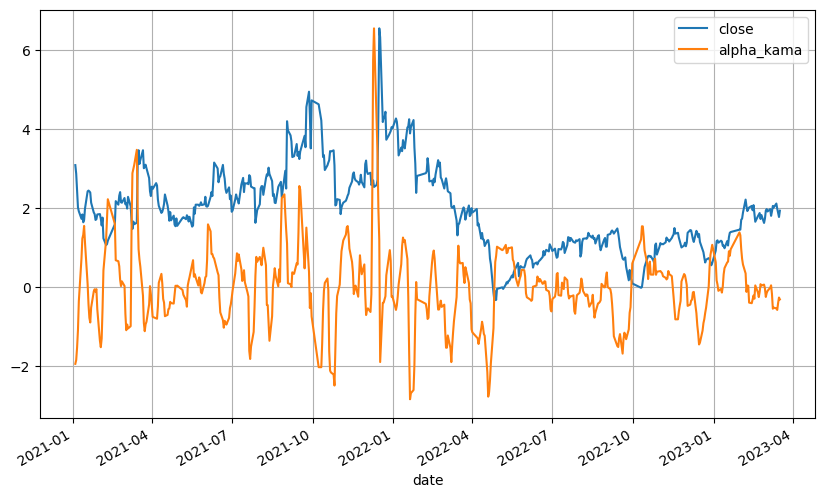

In [217]:
from scipy.stats import zscore
tmp = mnh.loc[(mnh['trade_date']>20210101)]

tmp[['close','close_10_kama_2_30', 'close_10_kama_5_30']].plot(grid=True)
tmp[['close_5_sma','alpha_kama']] = tmp[['close_5_sma','alpha_kama']].apply(zscore)
tmp['close'] = tmp['close']-6
tmp[['close','alpha_kama']].plot(grid=True)
#tmp[['volume_ratio', 'turnover_rate']].plot(grid=True)